<hr>

# Table of Content:
1. Problem Statement
2. Loading Library
3. Preprocessing
4. EDA
5. Model Training
6. Model Evaluations / Parameter Tuning
7. Observations/Conclusion 

<hr>

# 1. Problem Statement:

- The goal of the sarcasm detection NLP project using logistic regression for headlines is to create an accurate and reliable model that can automatically determine whether a particular headline is sarcastic. 
- With the vast amount of textual data accessible online, the ability to distinguish between sarcastic and non-sarcastic content is becoming increasingly essential. 
- This has a wide range of uses, including social media monitoring, online reputation management, and sentiment analysis. 
- The primary aim of this project is to provide a solution that can identify sarcastic headlines efficiently and effectively, thereby improving the accuracy and reliability of NLP applications.

# 2. Loading Library:
- Uncomment the below code if requirements are not installed.

In [1]:
# !pip install -r requirements.txt

In [2]:
# Importing the necessary library

import re
import string
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

In [3]:
# Loading the data

data = pd.read_json(
    "/kaggle/input/news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset_v2.json"
    , lines=True)

In [4]:
# Checking the shape of the data

data.shape

(28619, 3)

In [5]:
# Displaying the first ten rows of the dataset

data.head(10)

,is_sarcastic,headline,article_link
0,1,thirtysomething scientists unveil doomsday clo...,https://www.theonion.com/thirtysomething-scien...
1,0,dem rep. totally nails why congress is falling...,https://www.huffingtonpost.com/entry/donna-edw...
2,0,eat your veggies: 9 deliciously different recipes,https://www.huffingtonpost.com/entry/eat-your-...
3,1,inclement weather prevents liar from getting t...,https://local.theonion.com/inclement-weather-p...
4,1,mother comes pretty close to using word 'strea...,https://www.theonion.com/mother-comes-pretty-c...
5,0,my white inheritance,https://www.huffingtonpost.com/entry/my-white-...
6,0,5 ways to file your taxes with less stress,https://www.huffingtonpost.com/entry/5-ways-to...
7,1,richard branson's global-warming donation near...,https://www.theonion.com/richard-bransons-glob...
8,1,shadow government getting too large to meet in...,https://politics.theonion.com/shadow-governmen...
9,0,lots of parents know this scenario,https://www.huffingtonpost.comhttp://pubx.co/6...


# Initial EDA

In [6]:
# Checking for null values

data.isnull().sum()

is_sarcastic    0
headline        0
article_link    0
dtype: int64

In [7]:
# Checking for duplicate values

data.duplicated().sum()

2

In [8]:
# Removing the duplicate values

data.drop_duplicates(inplace=True)

In [9]:
# Checking if duplicate values are removed

data.duplicated().sum()

0

In [10]:
# Displaying the counts of is_sarcastic

data.is_sarcastic.value_counts()

0    14984
1    13633
Name: is_sarcastic, dtype: int64

# 3. Preprocessing

In [11]:
# Displaying the datatypes of the columns of the dataset

data.dtypes

is_sarcastic     int64
headline        object
article_link    object
dtype: object

- We will remove all the columns that we don't need!
    - eg: article_link since its the link to article and not actual article we can skip that.

In [12]:
# Dropping the article_link column using drop()

data.drop(columns=['article_link'], inplace=True)

In [13]:
# Lowering the text in the column headline

data["headline"] = data["headline"].str.lower()
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep. totally nails why congress is falling...
2,0,eat your veggies: 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word 'strea...


In [14]:
# Removing the punctuations from the data 

PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

data["headline"] = data["headline"].apply(lambda text: remove_punctuation(text))
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails why congress is falling ...
2,0,eat your veggies 9 deliciously different recipes
3,1,inclement weather prevents liar from getting t...
4,1,mother comes pretty close to using word stream...


In [15]:
# Removing the Stop words from the data

STOPWORDS = set(stopwords.words('english'))
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data["headline"] = data["headline"].apply(lambda text: remove_stopwords(text))
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


In [16]:
# Setting up counter to count word count

cnt = Counter()
for text in data["headline"].values:
    for word in text.split():
        cnt[word] += 1
        
cnt.most_common(10)

[('new', 1677),
 ('trump', 1389),
 ('man', 1373),
 ('report', 604),
 ('us', 601),
 ('one', 555),
 ('woman', 505),
 ('area', 494),
 ('says', 485),
 ('day', 475)]

In [17]:
# Remvoe the Frequent used words

FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    """custom function to remove the frequent words"""
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data["headline"] = data["headline"].apply(lambda text: remove_freqwords(text))
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


In [18]:
# Remove rarely occuring words from data

n_rare_words = 10
RAREWORDS = set([w for (w, wc) in cnt.most_common()[:-n_rare_words-1:-1]])
def remove_rarewords(text):
    """custom function to remove the rare words"""
    return " ".join([word for word in str(text).split() if word not in RAREWORDS])

data["headline"] = data["headline"].apply(lambda text: remove_rarewords(text))
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


In [19]:
# Extra custom preprocessing

def preprocess_signs(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    return text

data['headline'] = data['headline'].apply(preprocess_signs)
data.head()

,is_sarcastic,headline
0,1,thirtysomething scientists unveil doomsday clo...
1,0,dem rep totally nails congress falling short g...
2,0,eat veggies 9 deliciously different recipes
3,1,inclement weather prevents liar getting work
4,1,mother comes pretty close using word streaming...


# 4. EDA

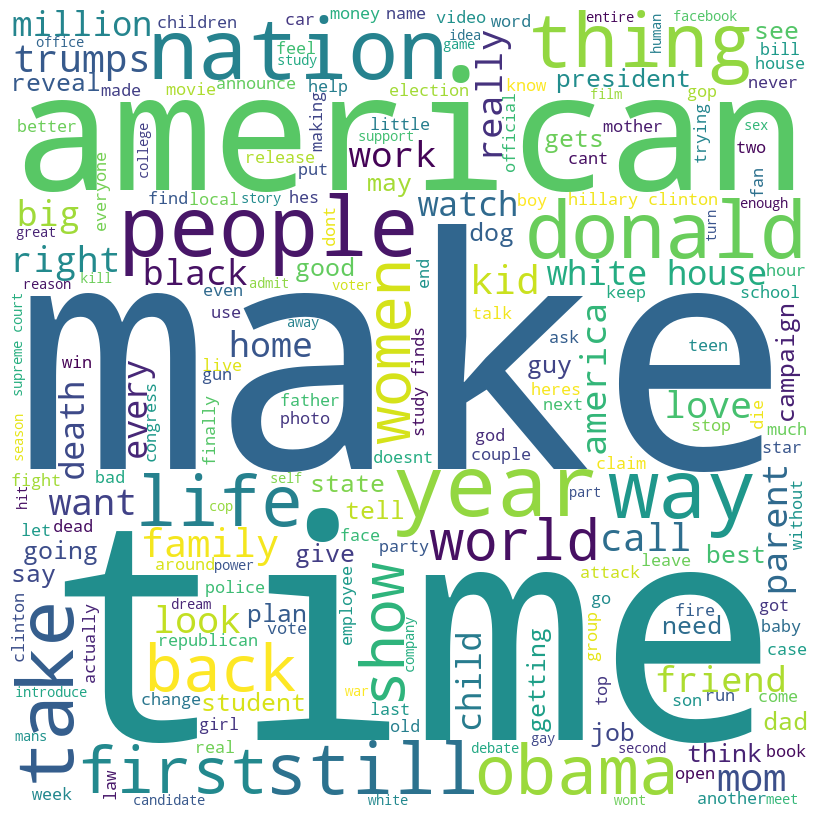

In [20]:
# Plotting the Word Cloud

data_ = " ".join(data["headline"])
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(data_)
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)

plt.show()

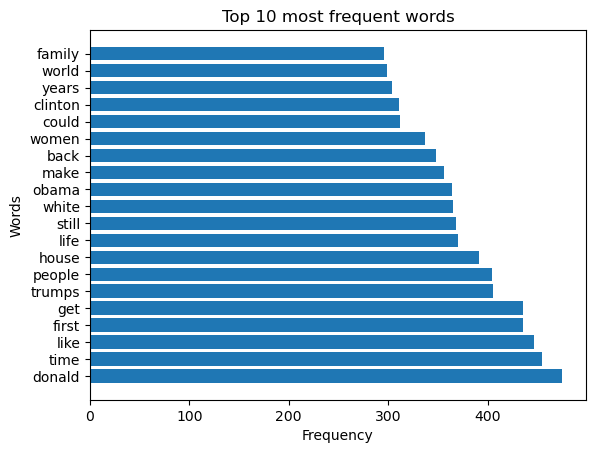

In [21]:
# Plotting Barchart 

# Concatenate all text data into a single string
text = ' '.join(data['headline'].tolist())

# Convert the text data to a dictionary of word frequencies
word_counts = {}
for word in text.split():
    if word not in word_counts:
        word_counts[word] = 0
    word_counts[word] += 1

# Get the top 10 most frequent words
top_words = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)[:20]

# Create a bar chart using matplotlib
plt.barh([word[0] for word in top_words], [word[1] for word in top_words])

plt.title('Top 10 most frequent words')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.show()

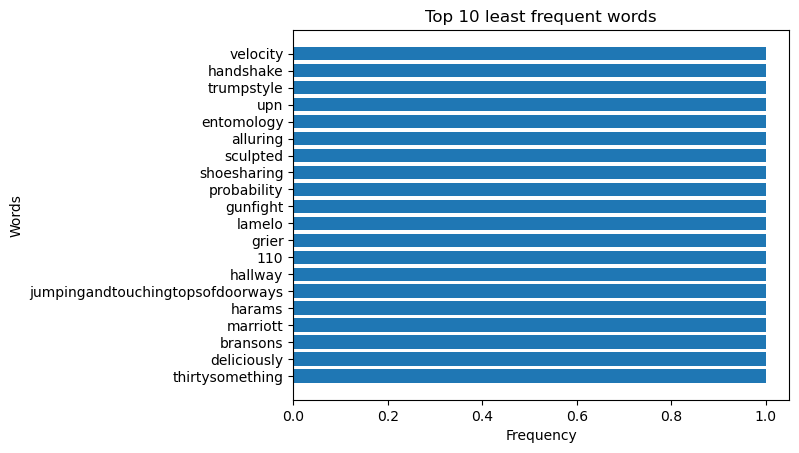

In [22]:
# Plotting Barchart 

# Convert the text data to a dictionary of word frequencies
word_counts = {}
for word in text.split():
    if word not in word_counts:
        word_counts[word] = 0
    word_counts[word] += 1

# Get the top 10 least frequent words
least_frequent_words = sorted(word_counts.items(), key=lambda x: x[1])[:20]

# Create a bar chart using Matplotlib
plt.barh([word[0] for word in least_frequent_words], [word[1] for word in least_frequent_words])

plt.title('Top 10 least frequent words')
plt.xlabel('Frequency')
plt.ylabel('Words')

plt.show()

In [23]:
# Initializing and feeding the data to transform

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['headline'])
y = data['is_sarcastic']

In [24]:
# Splitting the dataset into training dataset and testing dataset

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Model Training:

In [25]:
# Initialization of Logistic Regression Model

clf = LogisticRegression()

In [26]:
# Feeding the training data

clf.fit(X_train, y_train)

LogisticRegression()

In [27]:
# Evaluate the classifier on the test set

y_pred = clf.predict(X_test)

In [28]:
# Displaying the output 

y_pred

array([0, 1, 1, ..., 0, 0, 1])

# 6. Evaluation of the Model:

In [29]:
# Calculating Accuracy Score and Displaying it

acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

Accuracy: 0.793675751222921


In [30]:
# Calculating Confusion Matrix and Displaying it

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:", cm)

Confusion Matrix: [[2476  531]
 [ 650 2067]]


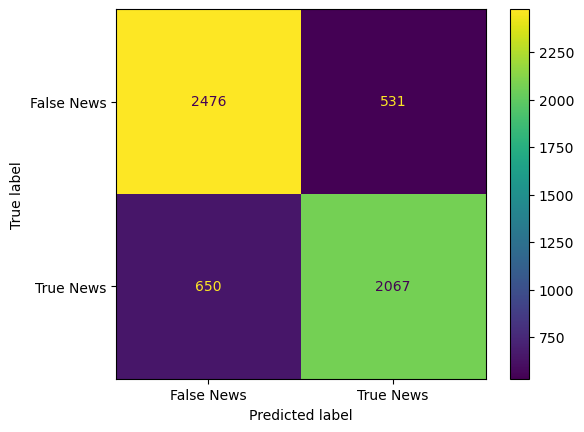

In [31]:
# Plotting the Confusion Matrix for Passive Aggressive

disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=["False News", "True News"])
disp.plot()
plt.show()

- **True positive** (TP): instances that are actually positive and are correctly predicted as positive. In this case, the count is 2476.
- **False positive** (FP): instances that are actually negative but are incorrectly predicted as positive. In this case, the count is 531.
- **False negative** (FN): instances that are actually positive but are incorrectly predicted as negative. In this case, the count is 650.
- **True negative** (TN): instances that are actually negative and are correctly predicted as negative. In this case, the count is 2067.

In [32]:
# Generate the classification report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.82      0.81      3007
           1       0.80      0.76      0.78      2717

    accuracy                           0.79      5724
   macro avg       0.79      0.79      0.79      5724
weighted avg       0.79      0.79      0.79      5724



### The classification report shown above is an evaluation of a sarcasm detection NLP model using logistic regression. Here's how to interpret the results:
- **Precision** is defined as the ratio of true positives to overall positive predictions. In this instance, the precision for class 0 (non-sarcastic) is 0.79, indicating that the model correctly classified 79% of the headlines as non-sarcastic. The precision for class 1 (sarcastic) is 0.80, which indicates that the model correctly classified 80% of the headlines as sarcastic.

- **Recall** is defined as the proportion of true positives to overall positives. The recall for class 0 in this instance is 0.82, indicating that the model correctly identified 82% of the non-sarcastic headlines. Class 1 has a recall of 0.76, indicating that the model correctly recognized 76% of the sarcastic headlines.

- **F1-score**: The harmonic mean of accuracy and recall is the F1-score. It gives a fair assessment of the model's performance. The F1-score for class 0 is 0.81, while the F1-score for class 1 is 0.78.

- The quantity of samples in each class is the **support**. In this instance, the test set contains 3007 non-sarcastic headlines and 2717 sarcastic headlines.

- **Accuracy** is defined as the proportion of accurate predictions to total predictions. The accuracy in this instance is 0.79, indicating that the model correctly classified 79% of the headlines in the test set.- 

### ROC Curve: 
- A **receiver operating characteristic (ROC) curve** is a plot that shows the trade-off between the true positive rate (TPR) and false positive rate (FPR) of a model. It is a useful tool for evaluating the performance of binary classifiers. You can use the scikit-learn library in Python to generate an ROC curve as follows:

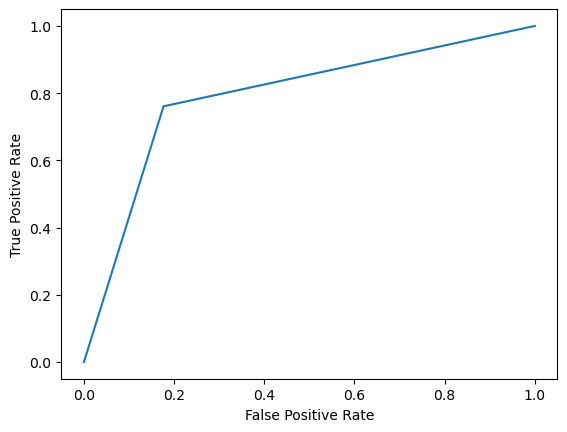

In [33]:
# Plotting ROC Curve

fpr, tpr, thresholds = roc_curve(y_test, y_pred)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

### Precision-Recall Curve: 
- A **precision-recall curve** is a plot that shows the trade-off between precision and recall of a model. It is a useful tool for evaluating the performance of binary classifiers when the classes are imbalanced. You can use the scikit-learn library in Python to generate a precision-recall curve as follows:

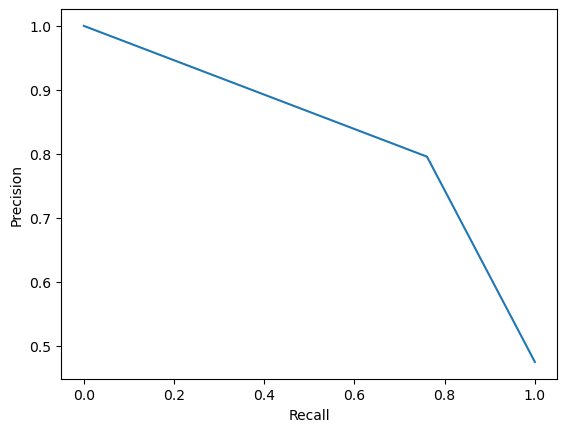

In [34]:
# plotting Precision Recall Curve

precision, recall, thresholds = precision_recall_curve(y_test, y_pred)
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# 7. Final Observations:
1. The model has an overall accuracy of 79%, which is a good performance for a binary classification task.
2. The precision and recall values are similar for both classes, with slightly higher precision for class 1 (sarcastic) and higher recall for class 0 (non-sarcastic).
3. The F1-score is 0.79, indicating a good overall performance of the model.
4. The ROC curve and precision-recall curve can provide additional insights into the performance of the model, especially when the classes are imbalanced.
5. The confusion matrix can help identify specific areas for improvement, such as reducing false positives or false negatives.
6. To improve the model's performance, we can try experimenting with different text preprocessing techniques, feature engineering methods, and hyperparameter tuning. 
7. We can also try using more advanced machine learning models, such as neural networks or ensemble methods.